# Using LightGBM as designed (not through sklearn API)

## Automatically Encode Categorical Columns

I've been encoding the geo_level columns as numeric this whole time. Can it perform better by using categorical columns?

LGBM can handle categorical features directly. No need to OHE them. But they must be ints. 

1. Load in X
2. Label Encode all the categorical features
 - All `object` dypes are categorical and need to be LabelEncoded

In [165]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import lightgbm as lgb
from pathlib import Path

### USE FOR LOCAL JUPYTER NOTEBOOKS ###
DOWNLOAD_DIR = Path("../download")
DATA_DIR = Path("../data")
SUBMISSIONS_DIR = Path("../submissions")
MODEL_DIR = Path("../models")
#######################################

X = pd.read_csv(DOWNLOAD_DIR / "train_values.csv", index_col="building_id")
categorical_columns = X.select_dtypes(include="object").columns
bool_columns = [col for col in X.columns if col.startswith("has")]

X_test = pd.read_csv(DOWNLOAD_DIR / "test_values.csv", index_col="building_id")
y = pd.read_csv(DOWNLOAD_DIR / "train_labels.csv", index_col="building_id")

In [97]:
sns.set()

In [2]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

label_enc = LabelEncoder()

t = [("ord_encoder", OrdinalEncoder(dtype=int), categorical_columns)]
ct = ColumnTransformer(transformers=t, remainder="passthrough")

In [5]:
X_all_ints = ct.fit_transform(X)
y = label_enc.fit_transform(
    y.reshape(
        -1,
    )
)

In [9]:
# Note that append for pandas objects works differently to append with
# python objects e.g. python append modifes the list in-place
# pandas append returns a new object, leaving the original unmodified
not_categorical_columns = X.select_dtypes(exclude="object").columns
cols_ordered_after_ordinal_encoding = categorical_columns.append(
    not_categorical_columns
)

In [10]:
cols_ordered_after_ordinal_encoding

Index(['land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'legal_ownership_status', 'geo_level_1_id',
       'geo_level_2_id', 'geo_level_3_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_

In [11]:
geo_cols = pd.Index(["geo_level_1_id", "geo_level_2_id", "geo_level_3_id"])
cat_cols_plus_geo = categorical_columns.append(geo_cols)

In [36]:
list(cat_cols_plus_geo)

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status',
 'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id']

In [12]:
train_data = lgb.Dataset(
    X_all_ints,
    label=y,
    feature_name=list(cols_ordered_after_ordinal_encoding),
    categorical_feature=list(cat_cols_plus_geo),
)

# train_data = lgb.Dataset(X_all_ints, label=y)

In [13]:
validation_data = lgb.Dataset("validation.svm", reference=train_data)

After reading through the docs for [lgb.train](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html) and [lgb.cv](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html), I had to make a separate function `get_ith_pred` and then call that repeatedly within `lgb_f1_score`. 

The function's docstring explains how it works. I have used the same argument names as in the LightGBM docs. This can work for any number of classes but does not work for binary classification. In the binary case, `preds` is a 1D array containing the probability of the positive class (it does not contain groups). 

In [83]:
# Taken from the docs for lgb.train and lgb.cv
# Helpful Stackoverflow answer:
# https://stackoverflow.com/questions/50931168/f1-score-metric-in-lightgbm
from sklearn.metrics import f1_score


def get_ith_pred(preds, i, num_data, num_class):
    """
    preds: 1D NumPY array
        A 1D numpy array containing predicted probabilities. Has shape
        (num_data * num_class,). So, For binary classification with
        100 rows of data in your training set, preds is shape (200,),
        i.e. (100 * 2,).
    i: int
        The row/sample in your training data you wish to calculate
        the prediction for.
    num_data: int
        The number of rows/samples in your training data
    num_class: int
        The number of classes in your classification task.
        Must be greater than 2.


    LightGBM docs tell us that to get the probability of class 0 for
    the 5th row of the dataset we do preds[0 * num_data + 5].
    For class 1 prediction of 7th row, do preds[1 * num_data + 7].

    sklearn's f1_score(y_true, y_pred) expects y_pred to be of the form
    [0, 1, 1, 1, 1, 0...] and not probabilities.

    This function translates preds into the form sklearn's f1_score
    understands.
    """
    # Does not work for binary classification, preds has a different form
    # in that case
    assert num_classs > 2

    preds_for_ith_row = [
        preds[class_label * num_data + i] for class_label in range(num_class)
    ]

    # The element with the highest probability is predicted
    return np.argmax(preds_for_ith_row)


def lgb_f1_micro(preds, train_data):
    y_true = train_data.get_label()

    num_data = len(y_true)
    num_class = 3

    y_pred = []
    for i in range(num_data):
        ith_pred = get_ith_pred(preds, i, num_data, num_class)
        y_pred.append(ith_pred)

    return "f1", f1_score(y_true, y_pred, average="micro"), True

In [28]:
probs = [[0.12, 0.18, 0.7], [0.2, 0.5, 0.3]]
[np.argmax(p) for p in probs]

[2, 1]

In [14]:
param = {
    "num_leaves": 120,
    #          'num_iterations': 240,
    "min_child_samples": 40,
    "learning_rate": 0.2,
    "boosting_type": "goss",
    "objective": "multiclass",
    "num_class": 3,
}

In [84]:
# LGBM seem to hate using plurals. Why???
num_round = 10
evals_result = {}
booster = lgb.train(
    param,
    train_data,
    num_round,
    categorical_feature=list(cat_cols_plus_geo),
    feval=lgb_f1_micro,
    evals_result=evals_result,
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 260601, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -2.339167
[LightGBM] [Info] Start training from score -0.564030
[LightGBM] [Info] Start training from score -1.094580


In [85]:
evals_result

{}

In [ ]:
lgb.plot_metric(evals_result)

In [64]:
booster.feature_importance()

array([  12,   45,   58,   31,   22,   34,    1,    2,  110,  845, 1618,
         23,  303,  140,   69,    5,   53,    7,   10,   10,   37,   16,
          4,    6,    5,    2,   63,   27,    4,    5,    3,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [88]:
# LGBM seem to hate using plurals. Why???
num_boost_round = 100
cv_results = lgb.cv(
    param,
    train_data,
    num_boost_round,
    nfold=5,
    categorical_feature=list(cat_cols_plus_geo),
    feval=lgb_f1_micro,
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choos

In [91]:
cv_results.keys()

dict_keys(['multi_logloss-mean', 'multi_logloss-stdv', 'f1-mean', 'f1-stdv'])

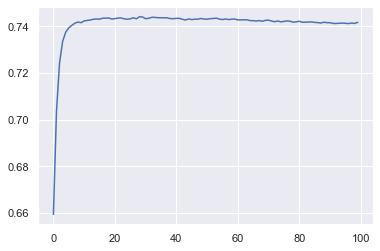

In [98]:
plt.plot(cv_results["f1-mean"])

In [94]:
f1_mean = cv_results["f1-mean"]
max(f1_mean)

0.7441529325991442

In [95]:
np.argmax(f1_mean)

28

In [103]:
len(f1_mean[20:35])

15

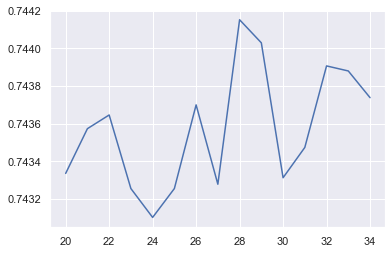

In [106]:
plt.plot(range(20, 35), f1_mean[20:35])
plt.xticks()
plt.show()

In [110]:
eval_results = {}
booster = lgb.train(
    param,
    train_data,
    28,
    #                     valid_sets=[validation_data],
    categorical_feature=list(cat_cols_plus_geo),
    feval=lgb_f1_micro,
    evals_result=evals_result,
)
#                     early_stopping_rounds=5)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 260601, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score -2.339167
[LightGBM] [Info] Start training from score -0.564030
[LightGBM] [Info] Start training from score -1.094580


In [113]:
booster.feature_importance()

array([  65,   74,  164,   58,   56,  134,   14,   12,  287, 2346, 4326,
        123,  834,  579,  295,   17,  105,   12,   25,   25,   70,   61,
         16,   20,    9,    5,  161,   67,    8,   20,    8,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [115]:
data = {"name": booster.feature_name(), "importance": booster.feature_importance()}
df_booster = pd.DataFrame(data)

In [116]:
df_booster

,name,importance
0,land_surface_condition,65
1,foundation_type,74
2,roof_type,164
3,ground_floor_type,58
4,other_floor_type,56
5,position,134
6,plan_configuration,14
7,legal_ownership_status,12
8,geo_level_1_id,287
9,geo_level_2_id,2346


## Submit this new model

This model with the native LightGBM API looks like an improvement over the sklearn implementation. Let's give it a whirl!

In [138]:
def make_submission_lgbm_api(booster, ct, title):
    """
    ct: ColumnTransformer
        The ColumnTransformer class already fit to X_train to label encode
        the features
    label_enc: LabelEncoder
        The LabelEncoder used to transform y to [0, 1, 2]
    """
    X_test = pd.read_csv(DOWNLOAD_DIR / "test_values.csv", index_col="building_id")

    X_test_ints = ct.transform(X_test)

    prediction_probabilities = booster.predict(X_test_ints)
    # Shift by 1 as submission is in format [1, 2, 3]
    predictions = [np.argmax(p) + 1 for p in prediction_probabilities]

    sub_format = pd.read_csv(
        DOWNLOAD_DIR / "submission_format.csv", index_col="building_id"
    )

    my_sub = pd.DataFrame(
        data=predictions, columns=sub_format.columns, index=sub_format.index
    )

    my_sub.to_csv(SUBMISSIONS_DIR / f"{title}.csv")

In [140]:
title = "02-26 LightGBM API - All features - 28 rounds - cat+geo are cat features"
make_submission_lgbm_api(booster, ct, title)

# Woop That Scored 0.7446 (with cv score of 0.7446) and pushed me up 100 places to 227

Let's remove some unimportant features

In [141]:
df_booster

,name,importance
0,land_surface_condition,65
1,foundation_type,74
2,roof_type,164
3,ground_floor_type,58
4,other_floor_type,56
5,position,134
6,plan_configuration,14
7,legal_ownership_status,12
8,geo_level_1_id,287
9,geo_level_2_id,2346


In [158]:
with open(DATA_DIR / "df_feature_importance_lgbm_api.pkl", "wb") as f:
    pickle.dump(df_booster, f)

In [159]:
with open(DATA_DIR / "df_feature_importance_lgbm_api.pkl", "rb") as f:
    a = pickle.load(f)

In [189]:
with open(DATA_DIR / "cat_cols_plus_geo.pkl", "wb") as f:
    pickle.dump(cat_cols_plus_geo, f)

Want to test now which features give the best performance and then submit the best one(s)

1. fi > 0
2. fi > 10
3. fi > 20
4. fi > 50
5. fi > 70
6. fi > 100
7. fi > 200
8. fi > 500
9. fi > 800
10. fi > 1000

In [151]:
# These are the features we want to include
keep = df_booster[df_booster.importance > 500].name.values
keep

array(['geo_level_2_id', 'geo_level_3_id', 'age', 'area_percentage'],
      dtype=object)

In [148]:
test = list(cols_ordered_after_ordinal_encoding)

In [149]:
test

['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status',
 'geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'count_families',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_sec

In [203]:
def cv_with_fi_range(keep_features=-1, num_boost_round=50):
    """
    Perform cv with native LightGBM API

    keep_feautures: int
        Keep features with feature importance greater than this value.
        Default: -1 to keep all features
    """

    X_train = pd.read_csv(DOWNLOAD_DIR / "train_values.csv", index_col="building_id")
    y_train = pd.read_csv(DOWNLOAD_DIR / "train_labels.csv", index_col="building_id")

    # Must ordinal encode the categorical columns for LGBM to work
    categorical_columns = X.select_dtypes(include="object").columns
    t = [("ord_encoder", OrdinalEncoder(dtype=int), categorical_columns)]
    ct = ColumnTransformer(transformers=t, remainder="passthrough")
    X_train_ints = ct.fit_transform(X_train)

    # Must label encode y (LGBM expects [0, 1, 2] as classes)
    label_enc = LabelEncoder()
    y_train = label_enc.fit_transform(np.ravel(y))

    non_cat_cols = X.select_dtypes(exclude="object").columns
    cols_after_ord_encoding = categorical_columns.append(non_cat_cols)
    # Turn into DF
    df_ints = pd.DataFrame(data=X_train_ints, columns=cols_after_ord_encoding)

    with open(DATA_DIR / "df_feature_importance_lgbm_api.pkl", "rb") as f:
        df_feature_importance = pickle.load(f)

    # Only keep features with FI > keep_features
    mask = df_feature_importance.importance > keep_features
    features_to_use = df_feature_importance[mask].name.values

    X_train_kept_features = df_ints[features_to_use]
    feature_names = list(df_ints[features_to_use].columns)

    # Need this to check which columns remain are categorical
    with open(DATA_DIR / "cat_cols_plus_geo.pkl", "rb") as f:
        cat_cols_plus_geo = pickle.load(f)

    # Create list of categorical features
    categorical_features = []
    for feature in feature_names:
        if feature in cat_cols_plus_geo:
            categorical_features.append(feature)

    train_dataset = lgb.Dataset(
        X_train_kept_features,
        label=y_train,
        feature_name=feature_names,
        categorical_feature=categorical_features,
    )

    param = {
        "num_leaves": 120,
        #          'num_iterations': 240,
        "min_child_samples": 40,
        "learning_rate": 0.2,
        "boosting_type": "goss",
        "objective": "multiclass",
        "num_class": 3,
    }

    cv_results = lgb.cv(
        param,
        train_dataset,
        num_boost_round,
        nfold=5,
        categorical_feature=categorical_features,
        feval=lgb_f1_micro,
    )

    f1_mean = cv_results["f1-mean"]

    fig, ax = plt.subplots()
    ax.plot(f1_mean)
    title = f"F1-score kept features above {keep_features} feature importance"
    ax.set(title=title, xlabel="Boosting round", ylabel="f1-score (micro)")
    plt.show()

    print(f"RESULTS KEEPING FEATURES > {keep_features} FEATURE IMPORTANCE")
    print("Best f1 score:          ", max(f1_mean))
    print("Best f1 score iteration:", np.argmax(f1_mean))

# TL;DR

Keeping features above feature importance 20 gives the best results: 0.7448 (in comparison to 0.7446 with all features). Do 26 iterations. 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 36
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10796
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features:

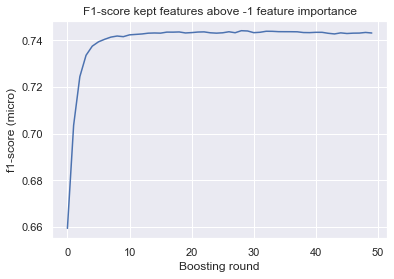

RESULTS KEEPING FEATURES > -1 FEATURE IMPORTANCE
Best f1 score:           0.7441529325991442
Best f1 score iteration: 28


In [214]:
cv_with_fi_range(-1)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10786
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 31
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10786
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 31
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10786
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 31
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choos

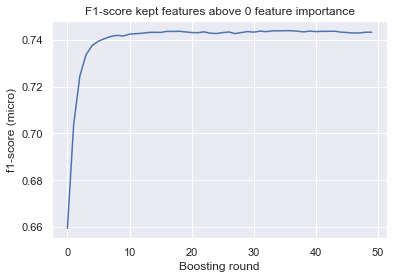

RESULTS KEEPING FEATURES > 0 FEATURE IMPORTANCE
Best f1 score:           0.7438459476850776
Best f1 score iteration: 35


In [213]:
cv_with_fi_range(0)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10778
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 27
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10778
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 27
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10778
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features:

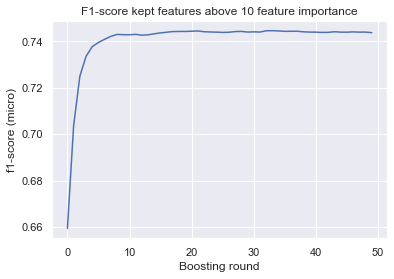

RESULTS KEEPING FEATURES > 10 FEATURE IMPORTANCE
Best f1 score:           0.744467587177561
Best f1 score iteration: 33


In [204]:
cv_with_fi_range(10)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10754
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10754
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10754
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 20
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choos

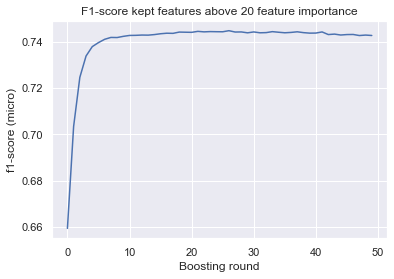

RESULTS KEEPING FEATURES > 20 FEATURE IMPORTANCE
Best f1 score:           0.7447553906788975
Best f1 score iteration: 26


In [205]:
cv_with_fi_range(20)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10750
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 18
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10750
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 18
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10750
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features:

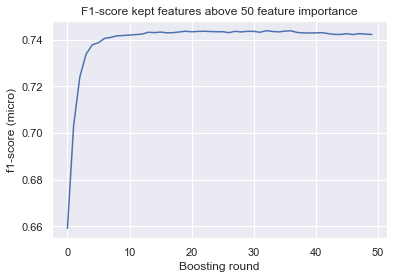

RESULTS KEEPING FEATURES > 50 FEATURE IMPORTANCE
Best f1 score:           0.743876649018328
Best f1 score iteration: 32


In [206]:
cv_with_fi_range(50)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10730
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 12
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10730
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 12
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

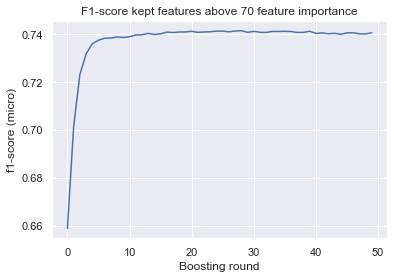

RESULTS KEEPING FEATURES > 70 FEATURE IMPORTANCE
Best f1 score:           0.7415205631744528
Best f1 score iteration: 28


In [207]:
cv_with_fi_range(70)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10725
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 11
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10725
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 11
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

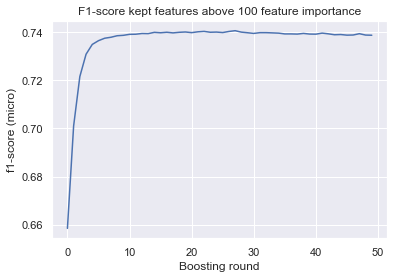

RESULTS KEEPING FEATURES > 100 FEATURE IMPORTANCE
Best f1 score:           0.7407185694725376
Best f1 score iteration: 27


In [208]:
cv_with_fi_range(100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10697
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 6
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10697
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 6
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

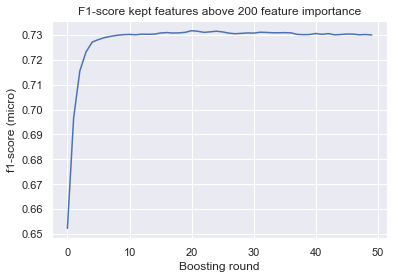

RESULTS KEEPING FEATURES > 200 FEATURE IMPORTANCE
Best f1 score:           0.7316855994058219
Best f1 score iteration: 20


In [209]:
cv_with_fi_range(200)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10640
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 4
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10640
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 4
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10640
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 4

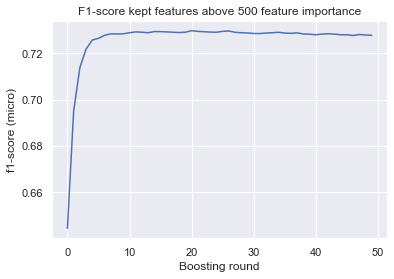

RESULTS KEEPING FEATURES > 500 FEATURE IMPORTANCE
Best f1 score:           0.7298475424599024
Best f1 score iteration: 20


In [210]:
cv_with_fi_range(500)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10565
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 3
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10565
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 3
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10565
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 3

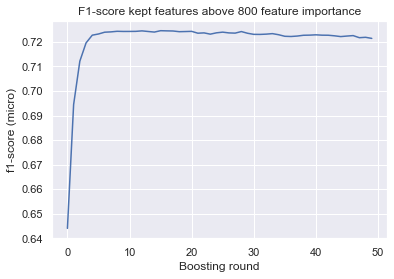

RESULTS KEEPING FEATURES > 800 FEATURE IMPORTANCE
Best f1 score:           0.7246019767774858
Best f1 score iteration: 15


In [211]:
cv_with_fi_range(800)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10528
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 2
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10528
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 2
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10528
[LightGBM] [Info] Number of data points in the train set: 208481, number of used features: 2
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Auto-choosing

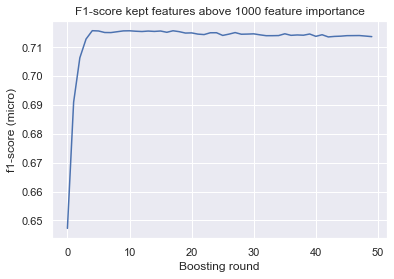

RESULTS KEEPING FEATURES > 1000 FEATURE IMPORTANCE
Best f1 score:           0.7156726192194934
Best f1 score iteration: 4


In [212]:
cv_with_fi_range(1000)

## Results

Keeping features with importance > 20 gives the best results